Mounted at /content/drive
Total data: 2849
Kolom: ['intent_id', 'role', 'intent_name', 'desc', 'utterence', 'entity']
Contoh data setelah preprocessing:
Data train: 2279
Data test: 570

Training model...
✅ Training selesai!

📊 Classification Report:
                                  precision    recall  f1-score   support

         admin_academic_year_add       0.50      0.40      0.44         5
      admin_academic_year_delete       1.00      0.80      0.89         5
  admin_academic_year_transition       0.83      1.00      0.91         5
      admin_academic_year_update       0.67      0.80      0.73         5
        admin_academic_year_view       0.83      1.00      0.91         5
            admin_achivement_add       0.33      0.20      0.25         5
         admin_achivement_delete       0.50      0.40      0.44         5
         admin_achivement_update       0.67      0.80      0.73         5
           admin_achivement_view       0.20      0.20      0.20         5
         

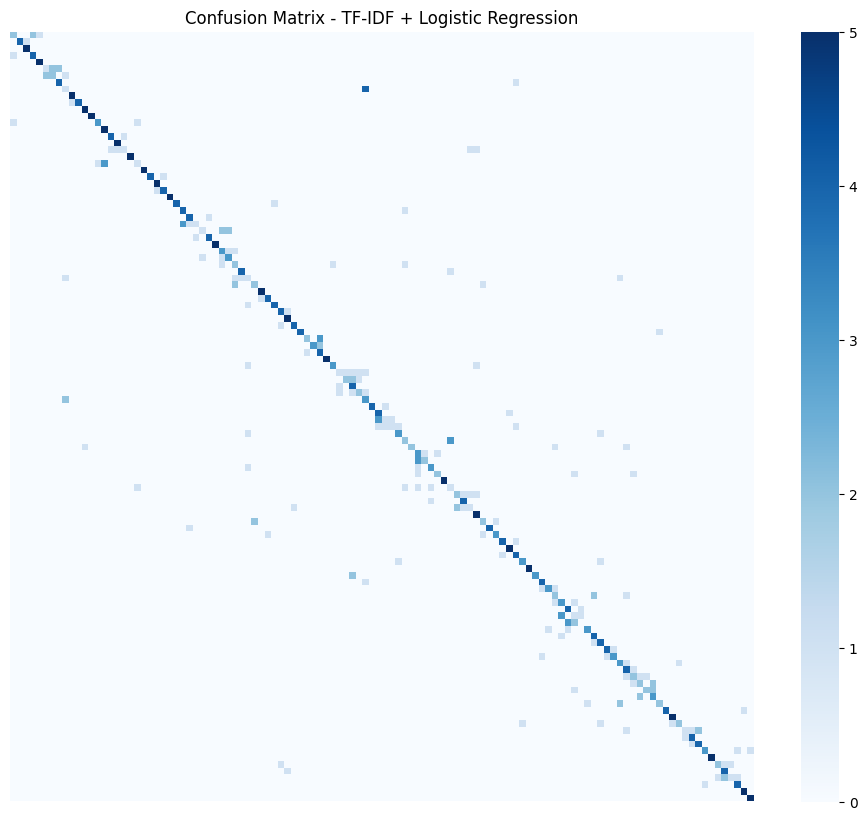

🗣️ 'Tolong tambahkan data guru baru' → 🎯 admin_teacher_add (confidence=0.22)
🗣️ 'Saya ingin tahu nilai anak saya tahun 2024' → 🎯 parents_student_chart_nilai (confidence=0.09)
🗣️ 'Coba tampilkan grafik absensi siswa' → 🎯 student_chart_kehadiran (confidence=0.11)
🗣️ 'Hapus data murid yang salah' → 🎯 admin_student_delete (confidence=0.08)
✅ Model disimpan di /content/drive/My Drive/Colab Notebooks/Uchat/Model/intent_classifier_tfidf_lr.pkl


In [ ]:
# ================================================================
# 1️⃣ Mount Google Drive
# ================================================================
from google.colab import drive
drive.mount('/content/drive')

# ================================================================
# 2️⃣ Load Dataset
# ================================================================
import pandas as pd

data_path = "/content/drive/My Drive/Colab Notebooks/Uchat/Dataset/dataset.csv"
df = pd.read_csv(data_path)

print("Total data:", len(df))
print("Kolom:", list(df.columns))
df.head(10)

# ================================================================
# 3️⃣ Preprocessing
# ================================================================
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9à-ž\s]', '', text)  # hapus simbol
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tambahkan role ke teks agar kontekstual (sama seperti pendekatan 2 di IndoBERTweet)
df["clean_text"] = df["role"] + " : " + df["utterence"].apply(clean_text)
df["intent"] = df["intent_name"]

print("Contoh data setelah preprocessing:")
df[["role", "utterence", "clean_text", "intent"]].head()

# ================================================================
# 4️⃣ Stratified Split (sama seperti BERT)
# ================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["intent"],
    test_size=0.2,
    random_state=42,
    stratify=df["intent"]
)

print("Data train:", len(X_train))
print("Data test:", len(X_test))

# ================================================================
# 5️⃣ TF-IDF Vectorization + Logistic Regression Classifier
# ================================================================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Pipeline identik dengan baseline umum NLP
model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1, C=2.0))
])

print("\nTraining model...")
model.fit(X_train, y_train)
print("✅ Training selesai!")

# ================================================================
# 6️⃣ Evaluasi Model (sama seperti IndoBERTweet)
# ================================================================
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()

# ================================================================
# 7️⃣ Tes Prediksi Manual (identik dengan BERT)
# ================================================================
def predict_intent(text):
    cleaned = clean_text(text)
    pred = model.predict([cleaned])[0]
    prob = model.predict_proba([cleaned]).max()
    return pred, prob

sample_utterances = [
    "Tolong tambahkan data guru baru",
    "Saya ingin tahu nilai anak saya tahun 2024",
    "Coba tampilkan grafik absensi siswa",
    "Hapus data murid yang salah"
]

for utt in sample_utterances:
    intent, conf = predict_intent(utt)
    print(f"🗣️ '{utt}' → 🎯 {intent} (confidence={conf:.2f})")

# ================================================================
# 8️⃣ Simpan Model (opsional)
# ================================================================
import joblib

save_path = "/content/drive/My Drive/Colab Notebooks/Uchat/Model"
joblib.dump(model, f"{save_path}/intent_classifier_tfidf_lr.pkl")

print(f"✅ Model disimpan di {save_path}/intent_classifier_tfidf_lr.pkl")


In [ ]:
def predict_intent(text):
    cleaned = clean_text(text)
    pred = model.predict([cleaned])[0]
    prob = model.predict_proba([cleaned]).max()
    return pred, prob

sample_utterances = [
    ("admin", "Tolong tambahkan data guru baru"),
    ("ortu", "Saya ingin tahu nilai anak saya tahun 2024"),
    ("murid", "Coba tampilkan grafik absensi saya"),
    ("admin", "Hapus data murid yang salah")
]

for utt in sample_utterances:
    intent, conf = predict_intent(utt)
    print(f"🗣️ '{utt}' → 🎯 {intent} (confidence={conf:.2f})")

🗣️ '('admin', 'Tolong tambahkan data guru baru')' → 🎯 admin_teacher_add (confidence=0.20)
🗣️ '('ortu', 'Saya ingin tahu nilai anak saya tahun 2024')' → 🎯 parents_student_chart_nilai (confidence=0.15)
🗣️ '('murid', 'Coba tampilkan grafik absensi saya')' → 🎯 student_chart_kehadiran (confidence=0.23)
🗣️ '('admin', 'Hapus data murid yang salah')' → 🎯 admin_student_delete (confidence=0.10)
